# Edoardo Vacchini

L'obbiettivo posto è la creazione di un modello per la curva di potenza di turbine eoliche, ovvero della caratteristica che lega la velocità del vento alla potenza generata, partendo dalle misurazioni di due turbine di un parco eolico su un arco temporale di 4 mesi.

Il dataset è un file comma separated values (dataset.csv) composto da 4 colonne:
+ **TimeStamp**: che rappresentano il time stamp col formato [YYYY-MM-dd hh:mm:ss]
+ **turbine_power1**: la misura di potenza della prima turbina misurati in kiloWatt [kW]
+ **turbine_power10**: la misura di potenza della secona turbine misurati in kiloWatt [kW]
+ **ws**: la velocità del vento misurata in metri al secondo [m/s]

I campioni sono fatti a partire dalle 02:10:00 del 2020-11-24 ogni 10 minuti, ogni giorno vengono misurati 144 campioni, ad eccezione del primo in cui ce ne sono 131 e dell'ultimo in cui ce ne sono 112.

Prima della fase di identificazione del modello, va fatta una prima fase di pulizia dei dati, siccome come verrà evidenziato nella fase di plot dei dati, questi contengono molti outliers e dati sporchi.
Per prima cosa viene effettuata la lettura dei dati, distinguendo i dati della turbina 1 da quelli della turbina 10 in due DataFrame diversi

In [1]:
import pandas
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy.stats as stats
import scipy

dataset = pandas.read_csv('../datasets/dataset.csv')
turbine1 = pandas.DataFrame({'timestamp':dataset.TimeStamp,'windspeed':dataset.ws, 'power':dataset.turbine_power1})
turbine10 = pandas.DataFrame({'timestamp':dataset.TimeStamp, 'windspeed':dataset.ws, 'power':dataset.turbine_power10})

## Analisi esplorative sui dati

### Plot dei dati

La visualizzazione dei dati di analisi evidenzia come nella turbina 1 è stato applicato un curtailment vistoso, ovvero un cap della potenza prodotta, esplicitato da delle marcate linee orizzontali a un livello di potenza sui 1845 kW e sui 2400 kW.

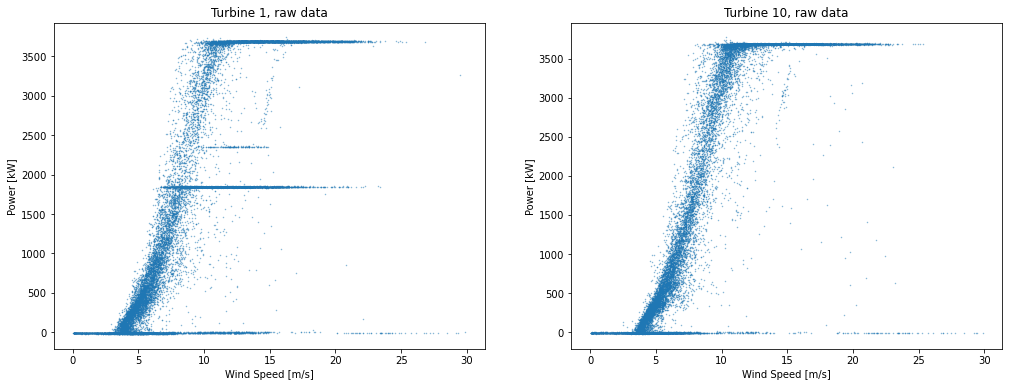

In [2]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (17,6))

ax[0].scatter(turbine1.windspeed, turbine1.power, s = 0.2, alpha = 0.6)
ax[0].set_xlabel('Wind Speed [m/s]')
ax[0].set_ylabel('Power [kW]')
ax[0].set_title('Turbine 1, raw data')

ax[1].scatter(turbine10.windspeed, turbine10.power, s = 0.2, alpha = 0.6)
ax[1].set_xlabel('Wind Speed [m/s]')
ax[1].set_ylabel('Power [kW]')
ax[1].set_title('Turbine 10, raw data')

plt.show()

Da notare come attorno allo zero si concentrino dati riguardanti la turbina spenta, quindi dati irrilevanti quantomeno sopra alla velocità di taglio della turbina. Inoltre dallo scatterplot si nota come la turbina 1 sia soggetta di curtailment attorno a 1850 kW e 2400 kW circa e come a 3650 kW si raggiunga la massima potenza.


### Istogramma e boxplot dei dati in un range specifico

Qui sotto viene inserito un piccolo script da eseguire per vedere gli istogrammi dei dati apparteneti a un determinato range di velocità del vento. Modificando le variabili upper e lower è possibile modificare tale range.

Per avere un istogramma quanto più significativo è necessario tenere un range stretto, ma non così stretto da racogliere pochi dati. Inoltre, siccome i dati negativi per velocità di vento positive sono dati legati al fatto che la turbia durante la misurazione era spenta, allora, sempre per avere un istogramma più significativo vengono selezionati solo i dati positivi.

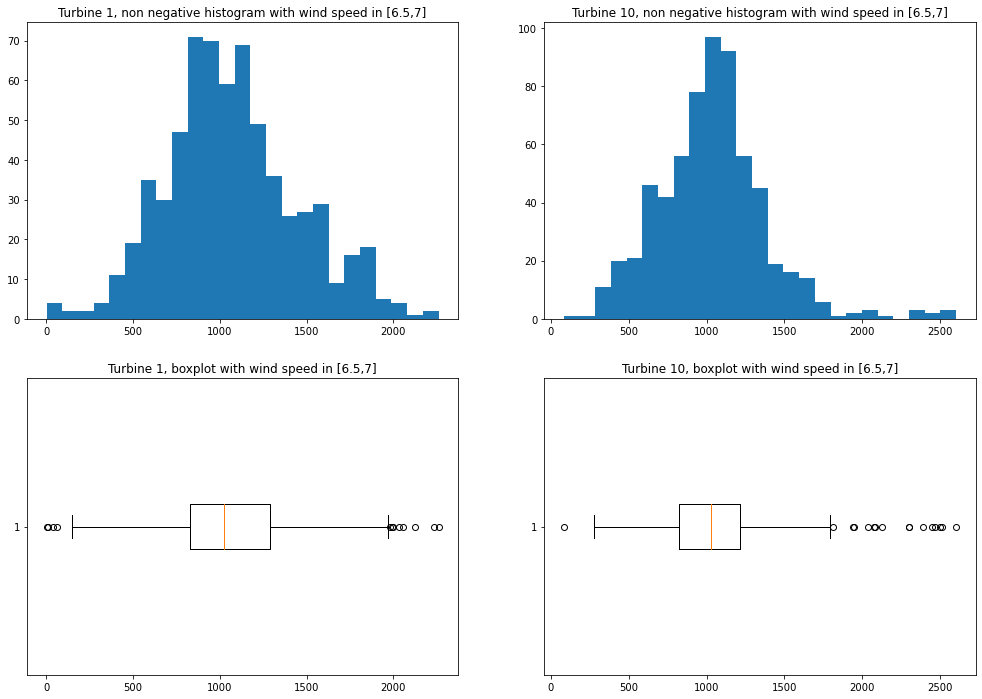

In [3]:
lower = 6.5
upper = 7

histogram1 = turbine1[((turbine1.windspeed > lower)&(turbine1.windspeed <= upper)&(turbine1.power>0))]
histogram10 = turbine10[((turbine10.windspeed > lower)&(turbine10.windspeed <= upper)&(turbine10.power>0))]

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (17,12))
ax[0,0].hist(histogram1.power, bins = int(math.sqrt(len(histogram1.power))))
ax[0,0].set_title("Turbine 1, non negative histogram with wind speed in [" + str(lower) + "," + str(upper) + "]")
ax[0,1].hist(histogram10.power, bins = int(math.sqrt(len(histogram10.power))))
ax[0,1].set_title("Turbine 10, non negative histogram with wind speed in [" + str(lower) + "," + str(upper) + "]")
ax[1,0].boxplot(histogram1.power, vert = False, whis = 1.5)
ax[1,0].set_title("Turbine 1, boxplot with wind speed in [" + str(lower) + "," + str(upper) + "]")
ax[1,1].boxplot(histogram10.power, vert = False, whis = 1.5)
ax[1,1].set_title("Turbine 10, boxplot with wind speed in [" + str(lower) + "," + str(upper) + "]")
plt.show()      

## Pulizia dei dati

### Pulizia dei dati Turbina 10

I dati della turbina 10 sono affetti da molti outliers e questa sezione del notebook si focalizza nella pulizia di questi. Un primo tentativo consiste nella suddivisione in intervalli piccoli (dati dalla variabile capillarity) l'asse delle velocità del vento, nel calcolo i quantili dei dati riferiti a quel range in quel range e nell'eliminazione di quelli che sono gli outliers del boxplot corrispondente.

I grafici generati sono il plot dei dati puliti e un istogramma che va comparato con quello della sezione sopra, siccome è l'istogramma della stessa sezione di dati.

In [4]:
whisker_length = 1
capillarity = 0.25
turbine10_clean = pandas.DataFrame(columns = ['timestamp', 'windspeed', 'power'])

for i in np.linspace(start = 0, stop = 30, endpoint = False, num = int(30 / capillarity)):
    lower_bound = i
    upper_bound = i + capillarity
    
    if upper_bound <= 4: #selezione dei dati
        data_interval =  turbine10[((turbine10.windspeed < upper_bound) & (turbine10.windspeed >= lower_bound))]
    elif upper_bound > 4 and upper_bound <= 13:
        data_interval =  turbine10[(((turbine10.windspeed < upper_bound) & (turbine10.windspeed >= lower_bound)) & (turbine10.power > 0))]
    elif upper_bound > 13:
        data_interval =  turbine10[(((turbine10.windspeed < upper_bound) & (turbine10.windspeed >= lower_bound)) & (turbine10.power > 2500))]
        
    quantiles = data_interval.quantile([.25, .75], axis = 'rows') # calcolo dei quantili al lato del boxplot
    boxplot_h = quantiles.power[0.75] - quantiles.power[0.25]
    boxplot_ends = [quantiles.power[0.25] - whisker_length*boxplot_h, quantiles.power[0.75] + whisker_length*boxplot_h]  
    data_interval = data_interval[(data_interval.power < boxplot_ends[1]) & (data_interval.power > boxplot_ends[0])] # eliminazione dati outliers
    turbine10_clean = turbine10_clean.append(data_interval, ignore_index = True)

L'istogramma dei dati puliti mostra come un'ipotesi di gaussianità dei dati non sarebbe infondata. E per evidenziare questo  fatto viene posta una gaussiana identificata da media e varianza campionaria dei dati considearti per l'istogramma.

Da notare è il cap di potenza sui 3650, che tronca la gaussiana. Quindi, prendendo intervalli con velocità del vento supriori a circa 8, sembra che la coda della gaussiana venga tutta concentrata all'altezza del cap.

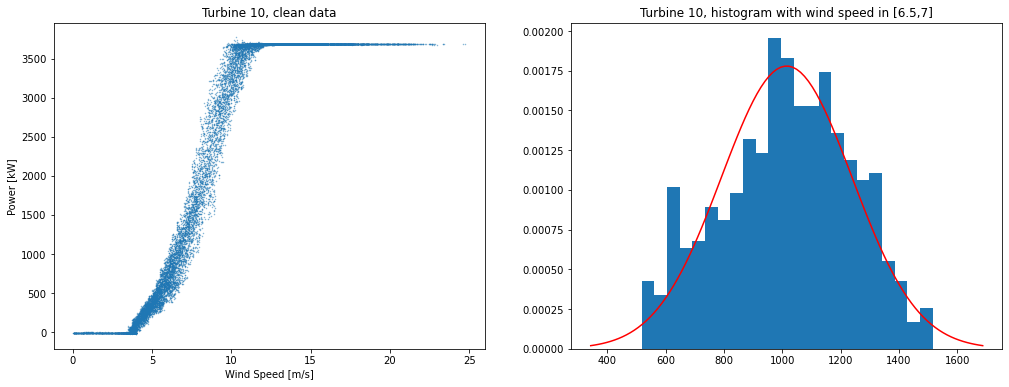

In [5]:
histogram10_clean = turbine10_clean[((turbine10_clean.windspeed > lower)&(turbine10_clean.windspeed <= upper))]
mu = np.mean(histogram10_clean.power)
sigma = math.sqrt(np.var(histogram10_clean.power))
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (17,6))
ax[0].scatter(turbine10_clean.windspeed, turbine10_clean.power, s = 0.2, alpha = 0.6)
ax[0].set_title('Turbine 10, clean data')
ax[0].set_xlabel('Wind Speed [m/s]')
ax[0].set_ylabel('Power [kW]')
ax[1].hist(histogram10_clean.power, bins = int(math.sqrt(len(histogram10_clean.power))), density = True)
ax[1].set_title("Turbine 10, histogram with wind speed in [" + str(lower) + "," + str(upper) + "]")
ax[1].plot(x, stats.norm.pdf(x, mu, sigma), color = 'r')
plt.show()

### Pulizia dei dati Turbina 1

La caratteristica preponderante dei dati della turbina 1 è la presenza di vari curtailment applicati. Il metodo di prima non basta, siccome i vari curtailment generano una grande quantità di dati che si raggruppano al livello del cap di potenza applicato, sbilanciando i quantili e quindi risultando in una pulizia praticamente nulla. La prima fase di pulizia dei dati è quella che permette di eliminare i dati del curtailment, per la seconda è applicabile la stessa tecnica di pulizia della turbina 10.

Per analizzare il problema si può vedere la distribuzione nel tempo del curtailment applicato plottando la massima potenza prodotta giornaliera.

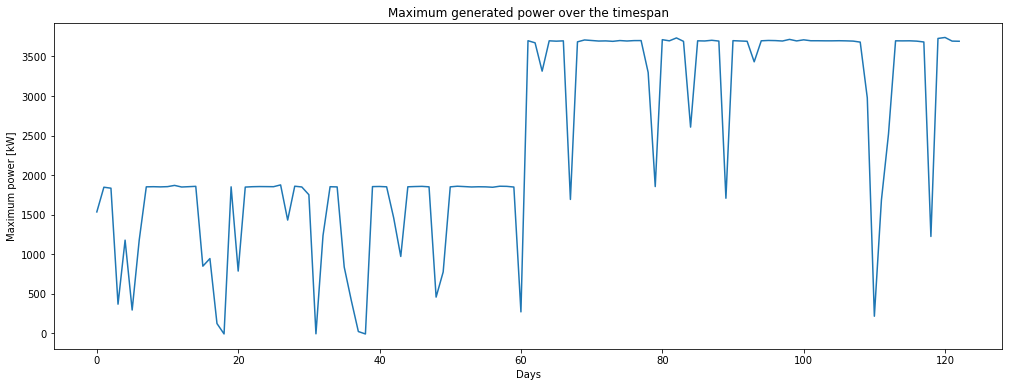

In [6]:
sample_first_day = 131
sample_per_day = 144
sample_last_day = 112
max_per_day = list()
days = list()

for day in range(123):
    start_day = (0 if day == 0 else sample_first_day + (day - 1)*sample_per_day) 
    end_day = (sample_first_day if day == 0 else sample_first_day + day*sample_per_day )
    turbine1_day = turbine1[start_day : end_day]
    max_per_day.append(max(turbine1_day.power))
    
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (17,6))
ax.plot(range(123), max_per_day)
ax.set_title('Maximum generated power over the timespan')
ax.set_xlabel('Days')
ax.set_ylabel('Maximum power [kW]')
plt.show()

Dal grafico si può osservare come la turbina sia stata usata per metà dei giorni osservati con un courtailmen a circa 1845 kW, e poi sia stata fatta andare a quello che si presume essere massimo della sua potenza generabile, ovvero all'incirca 3700 kW. Durante la seconda metà del periodo di osservazione ci sono comunque dei giorni in cui è attuato il courtailment dei giorni prima.

Allora può essere una buona mossa spezzare in due i dati nel mezzo e attuare strategie di pulizia diverse ma più semplici.

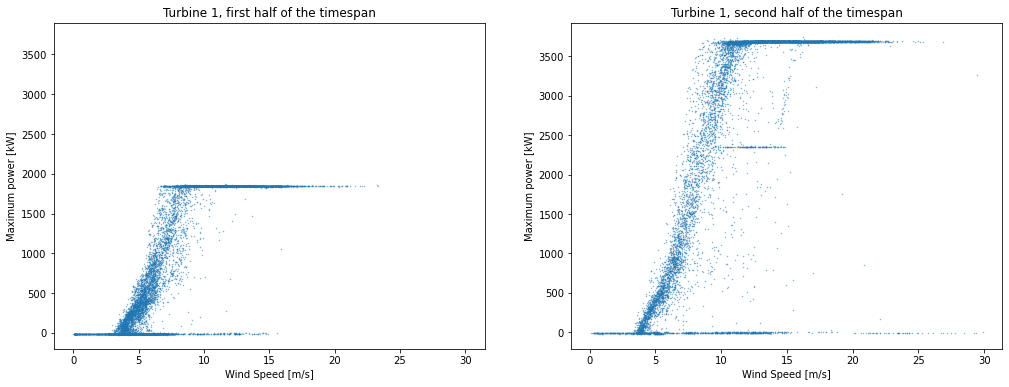

In [7]:
turbine1_fh = turbine1[0:int(len(turbine1)/2)]
turbine1_sh = turbine1[int(len(turbine1)/2) : len(turbine1)]

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (17,6))
ax[0].scatter(turbine1_fh.windspeed, turbine1_fh.power, s = 0.2, alpha = 0.6)
ax[0].set_ylim(-200, 3900)
ax[0].set_xlim(-1.5, 31.5)
ax[0].set_title('Turbine 1, first half of the timespan')
ax[0].set_xlabel('Wind Speed [m/s]')
ax[0].set_ylabel('Maximum power [kW]')

ax[1].scatter(turbine1_sh.windspeed, turbine1_sh.power, s = 0.2, alpha = 0.6)
ax[1].set_title('Turbine 1, second half of the timespan')
ax[1].set_xlabel('Wind Speed [m/s]')
ax[1].set_ylabel('Maximum power [kW]')
plt.show()

La prima metà dei dati potrebbe essere pulita semplicemente prendendo i dati compresi nel range (0, 1830), ovvero solo i dati non limitati manualmente, poi riunirli ai secondi dati per pulirli tutti insieme con il metodo dei quartili.

La seconda metà dei dati sono abbastanza simili ai dati della turbina 10, quindi lo stesso metodo di pulizia utilizzato per pulire i dati della prima turbina dovrebbe essere sufficiente. Il codice sotto è quindi copia-incollato dalla sezione di pulizia dei dati della turbina 1.

In [8]:
turbine1_fh_clean = turbine1_fh[(turbine1_fh.power < 1830) & (turbine1_fh.power > 0) & (turbine1_fh.windspeed < 10)]
turbine1_sh = turbine1_sh.append(turbine1_fh_clean)

In [9]:
whisker_length = 0.5
#capillarity = 0.25

turbine1_sh_clean = pandas.DataFrame(columns = ['timestamp', 'windspeed', 'power'])
for i in np.linspace(start = 0, stop = 30, endpoint = False, num = int(30 / capillarity)):
    lower_bound = i
    upper_bound = i + capillarity
    if upper_bound <= 4: #selezione dei dati
        data_interval =  turbine1_sh[((turbine1_sh.windspeed < upper_bound) & (turbine1_sh.windspeed >= lower_bound))]
    elif upper_bound > 4 and upper_bound <= 13:
        data_interval =  turbine1_sh[(((turbine1_sh.windspeed < upper_bound) & (turbine1_sh.windspeed >= lower_bound)) & (turbine1_sh.power > 0))]
    elif upper_bound > 13:
        data_interval =  turbine1_sh[(((turbine1_sh.windspeed < upper_bound) & (turbine1_sh.windspeed >= lower_bound)) & (turbine1_sh.power > 2500))] 
    
    quantiles = data_interval.quantile([.25, .75], axis = 'rows') # calcolo dei quantili al lato del boxplot
    boxplot_h = quantiles.power[0.75] - quantiles.power[0.25]
    boxplot_ends = [quantiles.power[0.25] - whisker_length*boxplot_h, quantiles.power[0.75] + whisker_length*boxplot_h]  
    
    data_interval = data_interval[(data_interval.power < boxplot_ends[1]) & (data_interval.power > boxplot_ends[0])] # eliminazione dati outliers
    turbine1_sh_clean = turbine1_sh_clean.append(data_interval, ignore_index = True)

Plottando lo scatterplot dei dati puliti e l'istogramma nel range referenziato più volte nel notebook, si può notare che un ipotesi di gaussianità dei dati non sembra lontana dalla realtà.

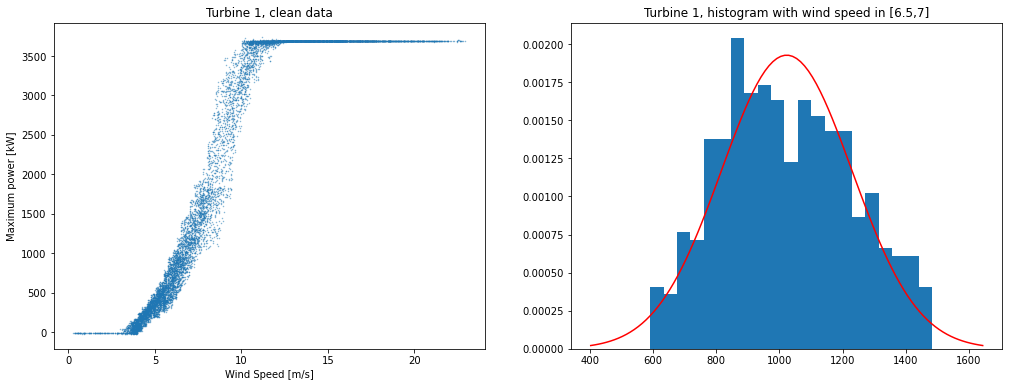

In [10]:
histogram1_clean = turbine1_sh_clean[(turbine1_sh_clean.windspeed < upper)&(turbine1_sh_clean.windspeed > lower)]
mu = np.mean(histogram1_clean.power)
sigma = math.sqrt(np.var(histogram1_clean.power))
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (17,6))
ax[0].scatter(turbine1_sh_clean.windspeed, turbine1_sh_clean.power, s = 0.2, alpha = 0.6)
ax[0].set_title('Turbine 1, clean data')
ax[0].set_xlabel('Wind Speed [m/s]')
ax[0].set_ylabel('Maximum power [kW]')

ax[1].hist(histogram1_clean.power, int(math.sqrt(len(histogram1_clean.power))), density = True)
ax[1].plot(x, stats.norm.pdf(x, mu, sigma), color = 'r')
ax[1].set_title('Turbine 1, histogram with wind speed in ['+str(lower)+','+str(upper)+']')

plt.show()

### Risultato della pulizia applicata

Riunendo i dati nello stesso DataFrame, si nota ancora di più come i dati riguardanti uno stesso range sembrino avere una distribuzione gaussiana.

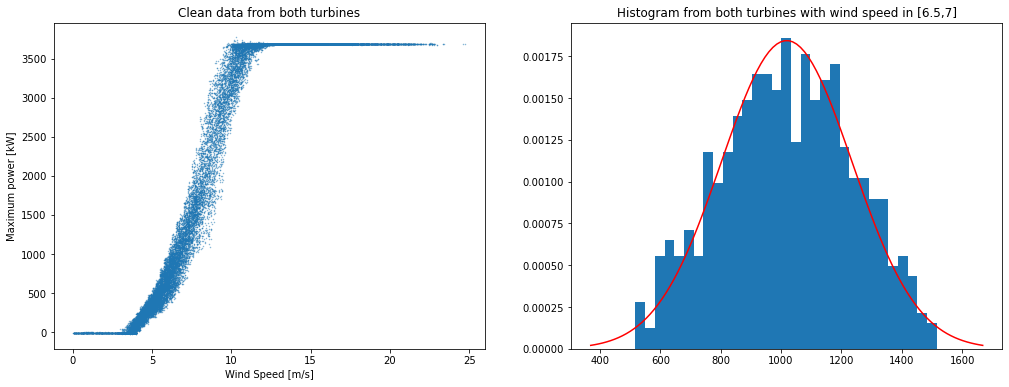

In [11]:
turbines = turbine1_sh_clean.append(turbine10_clean)
histogram_clean = histogram10_clean.append(histogram1_clean)
mu = np.mean(histogram_clean.power)
sigma = math.sqrt(np.var(histogram_clean.power))
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (17,6))
ax[0].scatter(turbines.windspeed, turbines.power, s = 0.2, alpha = 0.6)
ax[0].set_title('Clean data from both turbines')
ax[0].set_xlabel('Wind Speed [m/s]')
ax[0].set_ylabel('Maximum power [kW]')

ax[1].hist(histogram_clean.power, int(math.sqrt(len(histogram_clean.power))), density = True)
ax[1].plot(x, stats.norm.pdf(x, mu, sigma), color = 'r')
ax[1].set_title('Histogram from both turbines with wind speed in ['+str(lower)+','+str(upper)+']')

plt.show()

In [12]:
#turbines.to_csv('../datasets/clean_dataset.csv', header = True, sep = ',')